## Causal S-Learner Classifier

### TL; DR
---
This notebooks exemplifies how one can use the causal S-learner through fklearn.

### Data
---
The data here adopted is provided in [1], [2].

### REFERENCES

[1] https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

[2] https://github.com/matheusfacure/python-causality-handbook/tree/master/causal-inference-for-the-brave-and-true/data

### 1. Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fklearn.causal.cate_learning.meta_learners import causal_s_classification_learner
from fklearn.training.classification import lgbm_classification_learner
from fklearn.training.calibration import isotonic_calibration_learner
from fklearn.causal.validation.curves import cumulative_gain_curve
from fklearn.training.pipeline import build_pipeline
from fklearn.training.transformation import ecdfer

sns.set_style("darkgrid")

### 2. Functions

In [3]:
def plot_cumulative_gain_curve(
    train_gain: np.ndarray,
    test_gain: np.ndarray,
    random_gain: np.ndarray,
    fontsize: int = 16,
    figsize: tuple = (15,5)
) -> None:
    """
    Plots the cumulative gain curve.
    """

    xaxis = np.arange(len(train_gain))/len(train_gain)
    
    plt.figure(figsize=figsize);
    plt.plot(xaxis, train_gain, label="Training Data");
    plt.plot(xaxis, test_gain, label="Testing Data");
    plt.plot(xaxis, random_gain, "--", label="Random");
               
    plt.ylabel("Cumulative Gain", fontsize=fontsize);
    plt.xlabel("Population Proportion", fontsize=fontsize);
    plt.title("Cumulative Gain Curve", fontsize=fontsize);
               
    plt.legend(fontsize=fontsize);
    plt.xticks(fontsize=fontsize);
    plt.yticks(fontsize=fontsize);

### 3. Read Data

Notice that the data here adopted is provided in [1] and [2].

In [4]:
test_data = pd.read_csv(
    "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/invest_email_rnd.csv"
)
train_data = pd.read_csv(
    "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/invest_email_biased.csv"
)

In [5]:
test_data.shape

(15000, 8)

In [6]:
train_data.shape

(15000, 8)

#### 3.1 Include Treatment Column

In [7]:
train_data["treatment_col"] = np.where(
    train_data["em1"] == 1, "em1", "control"
)

test_data["treatment_col"] = np.where(
    test_data["em1"] == 1, "em1", "control"
)

In [8]:
train_data.head()

,age,income,insurance,invested,em1,em2,em3,converted,treatment_col
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,control
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,em1
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,control
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,control
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,em1


In [9]:
test_data.head()

,age,income,insurance,invested,em1,em2,em3,converted,treatment_col
0,44.1,5483.80,6155.29,14294.81,0,1,1,0,control
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,em1
2,49.0,2712.51,5707.08,5095.65,1,0,1,1,em1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0,em1
4,35.3,2787.26,27074.44,14114.86,1,1,1,0,em1


### 4. Causal S-Learner

In [10]:
target_column = "converted"
features = ["age", "income", "insurance", "invested"]
treatment_column = "treatment_col"
control_name = "control"
prediction_column = "prediction"

#### 4.1 Using S-Learner with LightGBM

In [11]:
clf_learner = lgbm_classification_learner(
    features = features,
    target = target_column,
    prediction_column = prediction_column
)

In [12]:
s_learner = causal_s_classification_learner(
    treatment_col=treatment_column,
    control_name=control_name,
    prediction_column=prediction_column,
    learner=clf_learner
)

**Training the model**

In [13]:
s_learner_fcn, s_learner_train_df, s_learner_log = s_learner(train_data)

[LightGBM] [Info] Number of positive: 3007, number of negative: 11993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200467 -> initscore=-1.383380
[LightGBM] [Info] Start training from score -1.383380


In [14]:
s_learner_fcn

<function fklearn.causal.cate_learning.meta_learners.causal_s_classification_learner.<locals>.p(new_df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame>

In [15]:
s_learner_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,treatment_col,treatment_em1__prediction_on_treatment,treatment_em1__prediction_on_control,treatment_em1__uplift,uplift,suggested_treatment
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,control,0.317353,0.213610,0.103743,0.103743,treatment_em1
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,em1,0.085400,0.103496,-0.018096,-0.018096,control
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,control,0.535527,0.323287,0.212240,0.212240,treatment_em1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,control,0.101604,0.083644,0.017960,0.017960,treatment_em1
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,em1,0.082496,0.032904,0.049591,0.049591,treatment_em1


In [16]:
s_learner_log

{'causal_s_classification_learner': {'causal_features': ['age',
   'income',
   'insurance',
   'invested',
   'is_treatment'],
  'em1': {'lgbm_classification_learner': {'features': ['age',
     'income',
     'insurance',
     'invested',
     'is_treatment'],
    'target': 'converted',
    'prediction_column': 'prediction',
    'package': 'lightgbm',
    'package_version': '3.3.2',
    'parameters': {'eta': 0.1, 'objective': 'binary', 'num_estimators': 100},
    'feature_importance': {'age': 713,
     'income': 741,
     'insurance': 757,
     'invested': 722,
     'is_treatment': 67},
    'training_samples': 15000,
    'running_time': '0.214 s'},
   'object': <lightgbm.basic.Booster at 0x12fb80280>}}}

**Making Predictions**

In [17]:
s_learner_test_df = s_learner_fcn(test_data)

In [18]:
s_learner_test_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,treatment_col,treatment_em1__prediction_on_treatment,treatment_em1__prediction_on_control,treatment_em1__uplift,uplift,suggested_treatment
0,44.1,5483.80,6155.29,14294.81,0,1,1,0,control,0.317353,0.213610,0.103743,0.103743,treatment_em1
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,em1,0.085400,0.103496,-0.018096,-0.018096,control
2,49.0,2712.51,5707.08,5095.65,1,0,1,1,em1,0.535527,0.323287,0.212240,0.212240,treatment_em1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0,em1,0.101604,0.083644,0.017960,0.017960,treatment_em1
4,35.3,2787.26,27074.44,14114.86,1,1,1,0,em1,0.082496,0.032904,0.049591,0.049591,treatment_em1


**Create Random Score**

Let's also create a random score that can be used to compute the Cumulative Gain curve.

In [19]:
random_score_df = test_data[["em1", target_column]].copy()
random_score_df["uplift"] = np.random.uniform(0,1,random_score_df.shape[0])

**Checking Cumulative Gain Curve**

For more details, please look at the following reference:

https://matheusfacure.github.io/python-causality-handbook/19-Evaluating-Causal-Models.html?highlight=gain%20curve    

In [20]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = "uplift"
)

In [21]:
gain_curve_train = gain_curve(s_learner_train_df)
gain_curve_test = gain_curve(s_learner_test_df)
gain_curve_random = gain_curve(random_score_df)

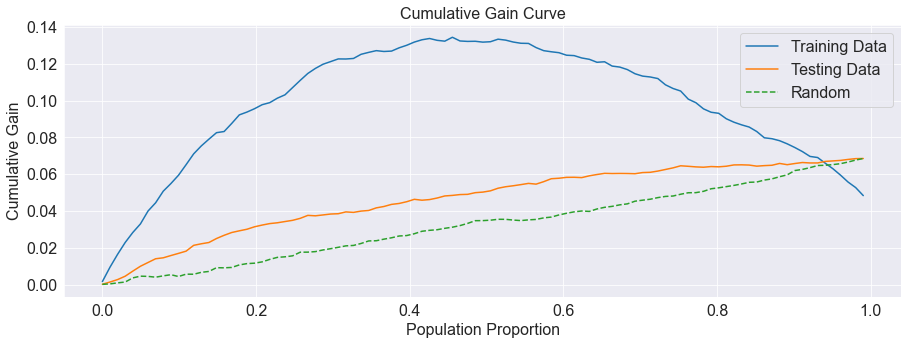

In [22]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)

#### 4.2 Using S-Learner with Fklearn Pipeline

In [23]:
cdf = ecdfer(
    prediction_column="uplift"
)

In [24]:
pipeline = build_pipeline(
    *[s_learner, cdf]
)

In [25]:
pipe_fcn, pipe_train_df, pipe_log = pipeline(
    train_data
)

[LightGBM] [Info] Number of positive: 3007, number of negative: 11993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200467 -> initscore=-1.383380
[LightGBM] [Info] Start training from score -1.383380


In [26]:
pipe_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,treatment_col,treatment_em1__prediction_on_treatment,treatment_em1__prediction_on_control,treatment_em1__uplift,uplift,suggested_treatment,prediction_ecdf
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,control,0.317353,0.213610,0.103743,0.103743,treatment_em1,705.533333
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,em1,0.085400,0.103496,-0.018096,-0.018096,control,29.866667
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,control,0.535527,0.323287,0.212240,0.212240,treatment_em1,924.933333
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,control,0.101604,0.083644,0.017960,0.017960,treatment_em1,131.333333
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,em1,0.082496,0.032904,0.049591,0.049591,treatment_em1,378.600000


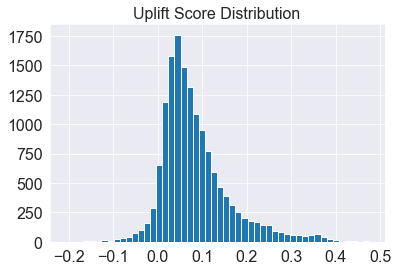

In [27]:
pipe_train_df["uplift"].hist(bins=50);
plt.title("Uplift Score Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

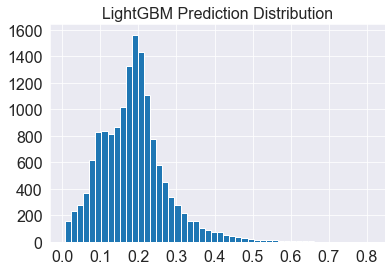

In [28]:
pipe_train_df["treatment_em1__prediction_on_control"].hist(bins=50);
plt.title("LightGBM Prediction Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

**Checking Gain Curve with ECDF**

In [29]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = "prediction_ecdf"
)

In [30]:
pipeline_train_df = pipe_fcn(train_data)
pipeline_test_df = pipe_fcn(test_data)

In [31]:
gain_curve_train = gain_curve(pipeline_train_df)
gain_curve_test = gain_curve(pipeline_test_df)

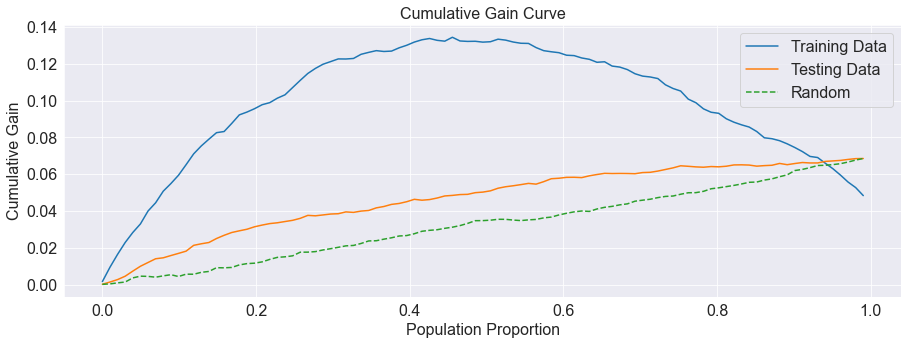

In [32]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)

#### 4.3 Build S-learner Using Lightgbm with Isotonic Calibration

In [33]:
clf_learner = lgbm_classification_learner(
    features = features,
    target = target_column,
    prediction_column = prediction_column
)

In [34]:
calibrator = isotonic_calibration_learner(
    target_column=target_column,
    prediction_column=prediction_column,
    output_column="calibration_prediction"
)

In [35]:
s_learner = causal_s_classification_learner(
    treatment_col=treatment_column,
    control_name=control_name,
    prediction_column="calibration_prediction",
    learner=clf_learner,
    learner_transformers=[calibrator]
)

In [36]:
cdf = ecdfer(
    prediction_column="uplift"
)

In [37]:
pipeline = build_pipeline(
    *[s_learner, cdf]
)

In [38]:
pipe_fcn, pipe_train_df, pipe_log = pipeline(
    train_data
)

[LightGBM] [Info] Number of positive: 3007, number of negative: 11993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200467 -> initscore=-1.383380
[LightGBM] [Info] Start training from score -1.383380


In [39]:
pipe_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,treatment_col,treatment_em1__calibration_prediction_on_treatment,treatment_em1__calibration_prediction_on_control,treatment_em1__uplift,uplift,suggested_treatment,prediction_ecdf
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,control,0.495652,0.179487,0.316165,0.316165,treatment_em1,765.933333
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,em1,0.002841,0.015385,-0.012544,-0.012544,control,39.666667
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,control,0.911894,0.517483,0.394412,0.394412,treatment_em1,853.400000
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,control,0.015385,0.002841,0.012544,0.012544,treatment_em1,143.266667
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,em1,0.002146,0.000000,0.002146,0.002146,treatment_em1,107.333333


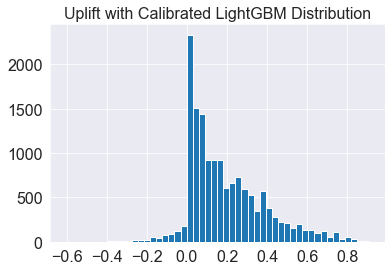

In [40]:
pipe_train_df["uplift"].hist(bins=50);
plt.title("Uplift with Calibrated LightGBM Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

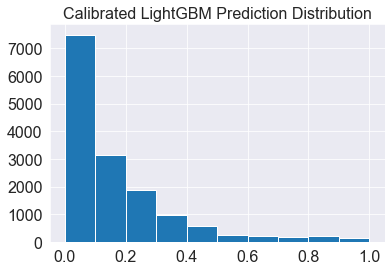

In [41]:
pipe_train_df["treatment_em1__calibration_prediction_on_control"].hist(bins=10);
plt.title("Calibrated LightGBM Prediction Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

**Checking Gain Curve with ECDF**

In [42]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = "prediction_ecdf"
)

In [43]:
pipeline_train_df = pipe_fcn(train_data)
pipeline_test_df = pipe_fcn(test_data)

In [44]:
gain_curve_train = gain_curve(pipeline_train_df)
gain_curve_test = gain_curve(pipeline_test_df)

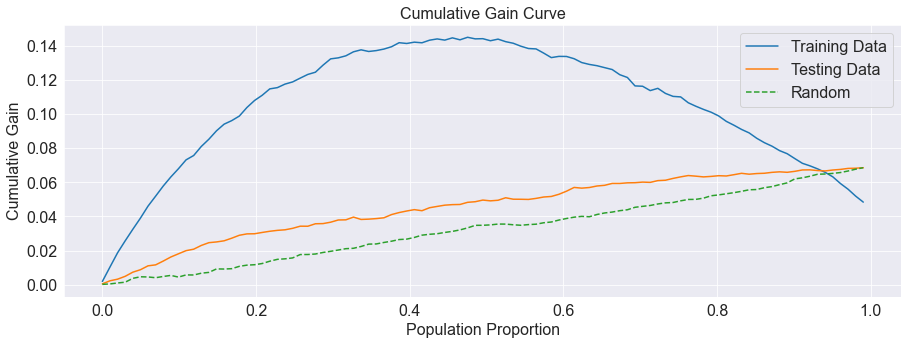

In [45]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)